In [1]:
import spacy
from typing import Tuple, Dict
from collections import defaultdict
import pandas as pd
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

In [2]:
nlp = spacy.load('en_core_web_md')

PATH_TO_FOUR_CLASSES_DATA = './NRC-Sentiment-Emotion-Lexicons/' \
                            'NRC-Affect-Intensity-Lexicon/NRC-AffectIntensity-Lexicon.csv'

PATH_TO_EIGHT_CLASSES_DATA = './NRC-Sentiment-Emotion-Lexicons/' \
                             'NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.csv'

POS_MULTIPLIER = {'ADJ': 1, 'ADV': 0.7, 'VERB': 0.5, 'NOUN': 0.3}

# reading first dataset
four_classes = pd.read_csv(PATH_TO_FOUR_CLASSES_DATA, names=['token', 'score', 'label'], sep=r"\s+")
# reading second dataset
eight_classes = pd.read_csv(PATH_TO_EIGHT_CLASSES_DATA, names=['token', 'label', 'score'], sep=r"\s+")

In [3]:
# clean text
def clean_text(text: str) -> str:
    doc = nlp(text)
    # removing stop words and punctuation
    tokens = ' '.join(
        [re.sub('\n', '', token.text.lower()) for token in doc if not token.is_stop and not token.is_punct])
    return tokens

In [4]:
# normalization of each result
def scale_dict_result(dict_):
    values = dict_.values()
    min_ = min(values)
    max_ = max(values)
    return {key: ((v - min_) / (max_ - min_)) for (key, v) in dict_.items()}

In [9]:
def eval_text(text: str, dataset: pd.DataFrame, multiply: bool) -> Tuple:
    doc = nlp(text)
    emotional_class = defaultdict(list)
    result_dict = {}
    for token in doc:
        multiplier = 1
        if multiply:
            # part of speech
            pos = token.pos_
            try:
                multiplier = POS_MULTIPLIER[pos]
            except KeyError:
                continue
        sub_df = dataset.loc[dataset.token == token.text]
        if not sub_df.empty:
            for index, row in sub_df.iterrows():
                tmp = [row['token'], float(row['score'])*multiplier]
                if tmp not in emotional_class[row['label']]:
                    emotional_class[row['label']].append(tmp)
    if 'positive' in emotional_class:
        emotional_class.pop('positive')
        emotional_class.pop('negative')
    # probabilities calc
    s = 0
    for k, _ in emotional_class.items():
        result_dict[k] = sum(map(lambda x: x[1], emotional_class[k]))
        s += result_dict[k]
    for k, v in result_dict.items():
        result_dict[k] = v / s
    return emotional_class, result_dict


In [10]:
# load text
filename = 'testText.txt'
file = open(filename, 'rt')
text = file.read()
file.close()


In [12]:
text = clean_text(text)
result1, d1 = eval_text(text, four_classes, multiply=False)
result2, d2 = eval_text(text, eight_classes, multiply=True)

display(result1)
display(d1)
display(result2)
display(d2)

# taking max values from each dataset, result2 is wider
aggregated_result = result2.copy()
for k, v in aggregated_result.items():
    if k in result1:
        aggregated_result[k] = max(result1[k], aggregated_result[k])

# labeling via min between emotional classes
labels = dict()
labels['high_positive'] = max([min(aggregated_result['joy'], aggregated_result['surprise']),
                               min(aggregated_result['joy'], aggregated_result['trust'])])
labels['positive'] = max([min(aggregated_result['joy'], aggregated_result['anticipation'])])
labels['neutral'] = max([min(aggregated_result['trust'], aggregated_result['anticipation']),
                         min(aggregated_result['surprise'], aggregated_result['anticipation'])])
labels['negative'] = max([min(aggregated_result['sadness'], aggregated_result['fear']),
                          min(aggregated_result['fear'], aggregated_result['anticipation'])])
labels['high_negative'] = max([min(aggregated_result['anger'], aggregated_result['disgust']),
                               min(aggregated_result['anger'], aggregated_result['fear']),
                               min(aggregated_result['disgust'], aggregated_result['fear'])])

defaultdict(list,
            {'anger': [['hate', 0.828],
              ['words', 0.062],
              ['bear', 0.266],
              ['hurt', 0.561],
              ['force', 0.418]],
             'fear': [['hide', 0.297],
              ['hate', 0.484],
              ['bear', 0.524],
              ['hurt', 0.688],
              ['pain', 0.594],
              ['problem', 0.266],
              ['force', 0.266]],
             'joy': [['live', 0.406],
              ['loving', 0.879],
              ['love', 0.828],
              ['heart', 0.547],
              ['pure', 0.364],
              ['soul', 0.401],
              ['happiness', 0.984]],
             'sadness': [['cry', 0.75],
              ['hate', 0.656],
              ['crying', 0.781],
              ['sad', 0.844],
              ['cried', 0.719],
              ['weakness', 0.516],
              ['hurt', 0.688],
              ['heartbreak', 0.781],
              ['torn', 0.71],
              ['pain', 0.719],
              ['proble

{'anger': 0.123660584998552,
 'fear': 0.18065450333043728,
 'joy': 0.2553721401679699,
 'sadness': 0.44031277150304077}

defaultdict(list,
            {'anger': [['wait', 0.0],
              ['day', 0.0],
              ['forget', 0.0],
              ['breath', 0.0],
              ['thing', 0.0],
              ['world', 0.0],
              ['loving', 0.0],
              ['love', 0.0],
              ['disguise', 0.0],
              ['hide', 0.0],
              ['long', 0.0],
              ['simulate', 0.0],
              ['crawl', 0.0],
              ['cry', 0.0],
              ['sleep', 0.0],
              ['hate', 0.5],
              ['crying', 0.0],
              ['feel', 0.0],
              ['people', 0.0],
              ['prefer', 0.0],
              ['words', 0.5],
              ['mouth', 0.0],
              ['heart', 0.0],
              ['bear', 0.5],
              ['words', 0.3],
              ['bring', 0.0],
              ['shed', 0.0],
              ['person', 0.0],
              ['sign', 0.0],
              ['weakness', 0.0],
              ['hurt', 0.5],
              ['torn', 0.0],
            

{'anger': 0.21212121212121213,
 'anticipation': 0.11363636363636365,
 'disgust': 0.060606060606060615,
 'fear': 0.23484848484848483,
 'joy': 0.08333333333333334,
 'sadness': 0.19696969696969696,
 'surprise': 0.022727272727272728,
 'trust': 0.07575757575757576}

In [194]:
display(labels)

{'high_positive': 0.2706766917293233,
 'positive': 0.21804511278195493,
 'neutral': 0.21804511278195493,
 'negative': 0.024006145573266753,
 'high_negative': 0.0}

In [195]:
from skfuzzy import trimf, trapmf
x = np.linspace(start = -1, stop = 1, num = 100)

In [196]:
m_functions = {}
m_functions['high_negative'] = trapmf(x, [-1, -1, -.8, -.2]) # high negative mem. function
m_functions['negative'] = trimf(x, [-.8, -0.2, 0]) # negative mem. function
m_functions['neutral'] = trimf(x, [-.2, 0, .2]) # neutral mem. function
m_functions['positive'] = trimf(x, [0, .2, .8]) # positive mem. function
m_functions['high_positive'] = trapmf(x, [.2, .8, 1, 1]) # high positive mem. function

In [197]:
mu_ = [m_functions[k] for k,_ in labels.items()]
mu_i = []
mu_i = [np.minimum(labels[k], m_functions[k]) for k,_ in labels.items()]
mu_s = np.max(mu_i, axis=0)
display(mu_s)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.003367  , 0.02400615, 0.02400615, 0.02400615, 0.02400615,
       0.02400615, 0.02400615, 0.02400615, 0.02400615, 0.02400615,
       0.02400615, 0.02400615, 0.02400615, 0.02400615, 0.02400615,
       0.02400615, 0.02400615, 0.02400615, 0.02400615, 0.02400615,
       0.02400615, 0.02400615, 0.02400615, 0.02400615, 0.02400615,
       0.02400615, 0.02400615, 0.02400615, 0.02400615, 0.02400615,
       0.04040404, 0.14141414, 0.21804511, 0.21804511, 0.21804511,
       0.21804511, 0.21804511, 0.21804511, 0.21804511, 0.21804511,
       0.21804511, 0.21804511, 0.21804511, 0.21804511, 0.21804511,
       0.21804511, 0.21804511, 0.21804511, 0.21804511, 0.21804511,
       0.21804511, 0.21804511, 0.21804511, 0.21804511, 0.21804511,
       0.21804511, 0.22222222, 0.25589226, 0.27067669, 0.27067669,
       0.27067669, 0.27067669, 0.27067669, 0.27067669, 0.27067

In [198]:
display(mu_i)

[array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.02020202, 0.05387205, 0.08754209, 0.12121212, 0.15488215,
        0.18855219, 0.22222222, 0.25589226, 0.27067669, 0.27067669,
        0.27067669, 0.27067669, 0.27067669, 0.27

In [199]:
# mass center calculation
y = np.trapz(x * mu_s, x=x) / np.trapz(mu_s, x=x)
display(y)

0.3983232285777777

In [200]:
label = list(labels.keys())
#label.reverse()
display(label)

['high_positive', 'positive', 'neutral', 'negative', 'high_negative']

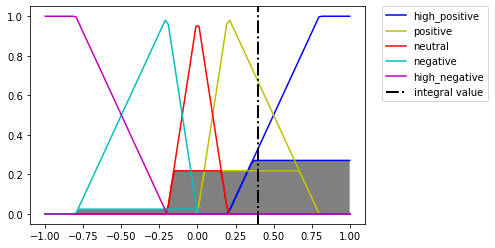

In [201]:
# ploting results
k = 0
colors = ['b', 'y', 'r', 'c', 'm']
for item in zip(mu_, mu_i):
    plt.plot(x, item[0], label=label[k], color=colors[k])
    plt.plot(x, item[1], color=colors[k])
    plt.fill_between(x, 0, item[1], facecolor='grey')
    k += 1
plt.axvline(x=y, ymin=0, ymax=1, color='black', linewidth=2, label='integral value', linestyle='-.')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)